In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

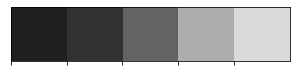

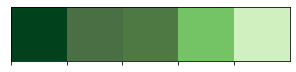

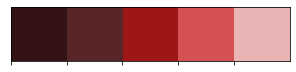

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

We start off by appending all the images from the directories into a Python list and then converting them into numpy arrays after resizing it.

In [5]:
labels = ['ART','BLA','EBO','EOS','LYT','MYB','NGS','PLM','PMO']

In [10]:
X_train = []
y_train = []

image_size = 250

for i in labels:
    folderPath = os.path.join('/Users/chiaravece/Desktop/Prova_Cellule/','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('/Users/chiaravece/Desktop/Prova_Cellule/','Validation',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|████████████████████████████████████████| 501/501 [00:00<00:00, 885.14it/s]


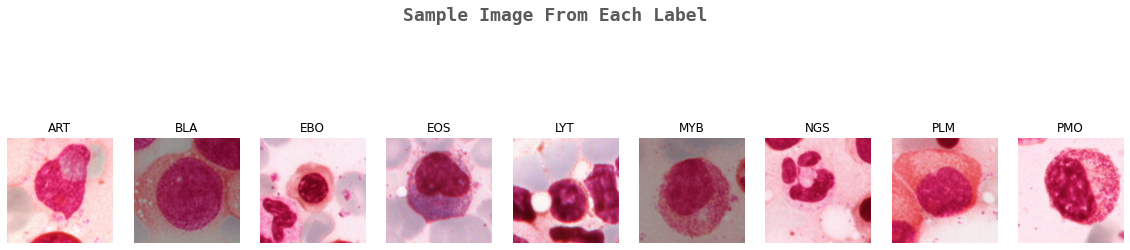

In [11]:
k=0

fig, ax = plt.subplots(1,9,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [12]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [13]:
X_train.shape

(18001, 250, 250, 3)

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [15]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [16]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

2022-11-23 12:47:28.612759: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-23 12:47:28.614374: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1


In [32]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(9,kernel_regularizer = regularizers.l2(l2=0.01), activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [33]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 250, 250, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 250, 250, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 250, 250, 3)  0           ['normalization[0][0]']    

In [34]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [35]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [36]:
history = model.fit(X_train, y_train, validation_split=0.1, epochs=9, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/9


2022-11-23 18:07:25.581332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


456/456 [==============================] - ETA: 0s - loss: 0.2845 - accuracy: 0.9412

2022-11-23 18:24:12.763037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.83148, saving model to effnet.h5
456/456 [==============================] - 1048s 2s/step - loss: 0.2845 - accuracy: 0.9412 - val_loss: 0.7532 - val_accuracy: 0.8315 - lr: 0.0010
Epoch 2/9
456/456 [==============================] - ETA: 0s - loss: 0.2359 - accuracy: 0.9435
Epoch 2: val_accuracy did not improve from 0.83148
456/456 [==============================] - 1043s 2s/step - loss: 0.2359 - accuracy: 0.9435 - val_loss: 0.8143 - val_accuracy: 0.8111 - lr: 0.0010
Epoch 3/9
456/456 [==============================] - ETA: 0s - loss: 0.1995 - accuracy: 0.9545
Epoch 3: val_accuracy did not improve from 0.83148

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
456/456 [==============================] - 805s 2s/step - loss: 0.1995 - accuracy: 0.9545 - val_loss: 0.6713 - val_accuracy: 0.8290 - lr: 0.0010
Epoch 4/9
456/456 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9815
Epoch 4: val_accura

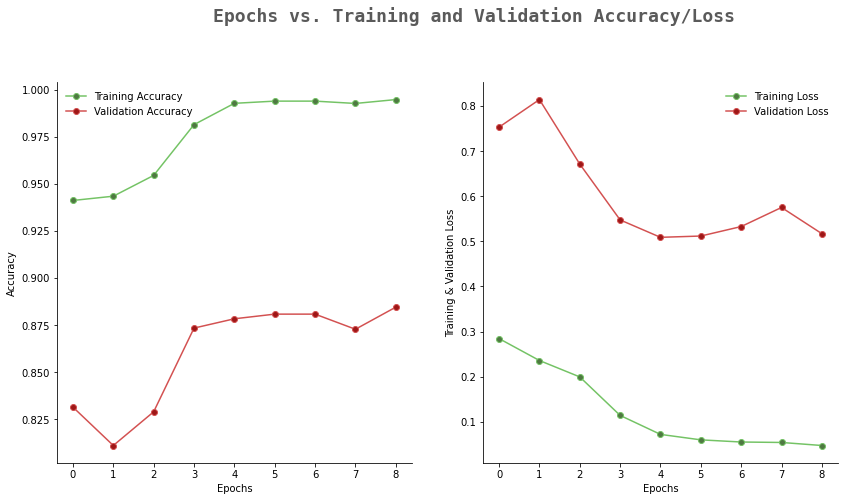

In [37]:
filterwarnings('ignore')

epochs = [i for i in range(9)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [38]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

2022-11-23 20:38:28.643173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


57/57 [==============================] - 24s 343ms/step


In [39]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.88      0.85      0.86       175
           1       0.84      0.88      0.86       219
           2       0.93      0.93      0.93       182
           3       0.98      0.97      0.98       193
           4       0.89      0.83      0.86       219
           5       0.83      0.70      0.76       200
           6       0.95      0.94      0.95       200
           7       0.89      0.93      0.91       211
           8       0.73      0.85      0.79       202

    accuracy                           0.88      1801
   macro avg       0.88      0.88      0.88      1801
weighted avg       0.88      0.88      0.88      1801



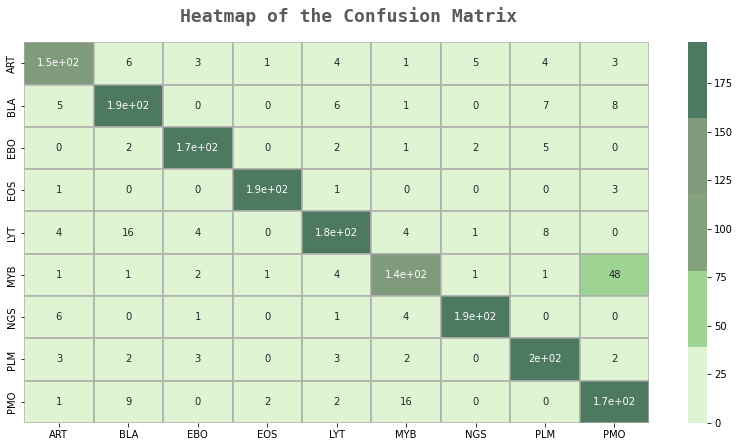

In [40]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [ ]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(250,250))
    img = img.reshape(1,250,250,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        print('The model predicts that is PMO')
    elif p==1:
        print('The model predicts that is PLM')
    elif p==2:
        print('The model predicts that is EOS')
    elif p==3:
        print('The model predicts that is EBO')
    elif p==4:
        print('The model predicts that is BLA')
    elif p==5:
        print('The model predicts that is ART')


In [ ]:
uploader = widgets.FileUpload()
display(uploader)

In [ ]:
type(uploader)

In [ ]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])